# 03 – Methane–air combustion in counterflow

In this notebook we use the velocity field computed in Part 1 to simulate
methane–air combustion in a counterflow configuration.

We proceed in two steps:
- Homogeneous reactor at fixed temperature : We assume a uniform temperature (e.g. 1000 K) and solve only the chemistry + species transport. This gives us a reference behaviour for the species mass fractions.
- Full reactive flow with energy equation : We then solve the full problem where temperature evolves due to chemical heat release and transport. From this simulation we obtain the species fields (CH4, O4, H2O, CO2) and the temperature field, and we track the maximum temperature in time.

All numerical parameters and physical constants are taken from `config.py`, while the Navier–Stokes solver, N₂ transport and combustion routines are implemented in `navier_stokes.py`, `transport.py` and `combustion.py`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from counterflow.config import default_params
from counterflow.grid import create_grid
from counterflow.navier_stokes import V0_cond, fractional_step
from counterflow.transport import YN2_0, calcul_YN2
import counterflow.combustion as combustion 
from counterflow.analysis import steady_time, compute_diffusive_thickness 

In [2]:
# Load default parameters 
params = default_params()

rho = params["rho"]
nu = params["nu"]
D = params["D"]
cp = params["cp"]
Lx = params["Lx"]
Nx = params["Nx"]
Tf = params["Tf"]
Nt = params["Nt"]
dt = params["dt"]

print("Simulation parameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

x, y, dx, dy = create_grid(Lx=Lx, Nx=Nx)

# IMPORTANT: combustion.py uses a global dx variable
combustion.dx = dx  # inject dx into module namespace


Simulation parameters:
  rho: 1.1614
  nu: 1.5e-05
  D: 1.5e-05
  cp: 1200
  Lx: 0.002
  Ly: 0.002
  Nx: 50
  Ny: 50
  Tf: 0.01
  Nt: 3000
  dt: 3.334444814938313e-06


In [4]:
# Initial conditions for Navier–Stokes
U0 = np.zeros(Nx * Nx)      
V0 = V0_cond(Nx)            
P0 = np.zeros(Nx * Nx)      

print("Running fractional-step Navier–Stokes solver...")
p_flat, u_flat, v_flat = fractional_step(U0, V0, P0, dt, dx, nu, Nt, Nx, rho)

# Detect steady state time 
Nstat, tstat = steady_time(Nx, Nt, p_flat, dt, eps=1e-8)
print(f"Steady state reached at t = {tstat:.4e} s (iteration {Nstat})")

# Reshape to 3D arrays (Ny, Nx, Nt) for easier access
u = np.reshape(u_flat, (Nx, Nx, Nt))
v = np.reshape(v_flat, (Nx, Nx, Nt))
p = np.reshape(p_flat, (Nx, Nx, Nt))

Running fractional-step Navier–Stokes solver...
Condition number: 34607994010.898506
Steady state reached at t = 5.0817e-03 s (iteration 1524)


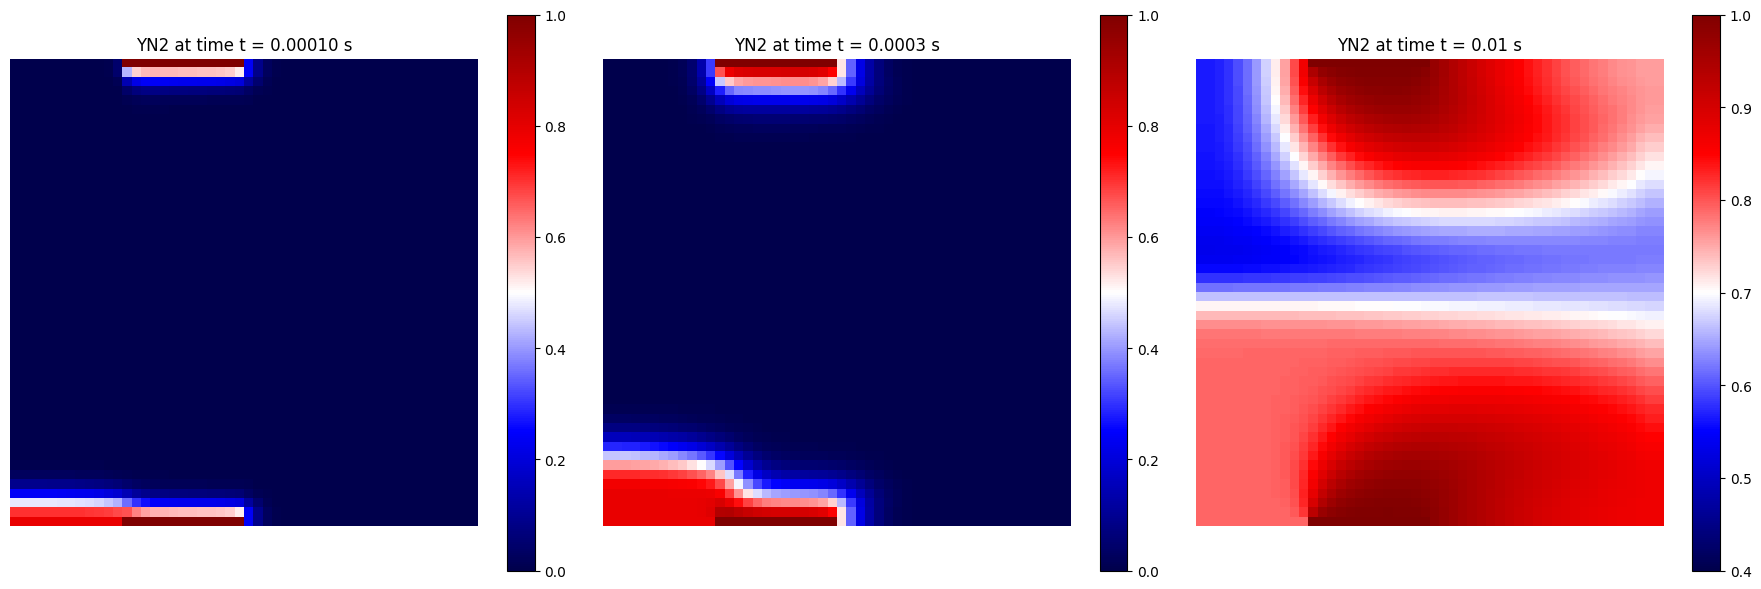

In [6]:
# N2 initial condition and transport (spectator specie)
YN2_calc, time_yn2 = calcul_YN2(u_flat, v_flat, YN2_0, dt, dx, D, Nt, Nx, rho)

fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6))  

im12 = axs2[0].imshow(np.reshape(YN2_calc, (Nx, Nx, 4))[:, :, 1], cmap='seismic')
axs2[0].set_title(f"YN2 at time t = {time_yn2[1]:.5f} s")
axs2[0].invert_yaxis()
axs2[0].axis('off')
fig2.colorbar(im12, ax=axs2[0])

im21 = axs2[1].imshow(np.reshape(YN2_calc, (Nx, Nx, 4))[:, :, 2],cmap='seismic')
axs2[1].set_title(f"YN2 at time t = {time_yn2[2]:.4f} s")
axs2[1].invert_yaxis()
axs2[1].axis('off')
fig2.colorbar(im21, ax=axs2[1])

im32 = axs2[2].imshow(np.reshape(YN2_calc, (Nx, Nx, 4))[:, :, 3],cmap='seismic',vmin=0.4, vmax=1.0)
axs2[2].set_title(f"YN2 at time t = {time_yn2[3]:} s")
axs2[2].invert_yaxis()
axs2[2].axis('off')
fig2.colorbar(im32, ax=axs2[2])

plt.tight_layout()
plt.show()

In [7]:
def plot_species_snapshots(field_flat, times, Nx, title_prefix, cmap="seismic",vmin=None, vmax=None):
    field = np.reshape(field_flat, (Nx, Nx, 4))
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for k_plot, snap_idx in enumerate([1, 2, 3]):
        ax = axes[k_plot]
        im = ax.imshow(field[:, :, snap_idx], cmap=cmap,
                       vmin=vmin, vmax=vmax)
        ax.set_title(f"{title_prefix} at t = {times[snap_idx]:.4e} s")
        ax.invert_yaxis()
        ax.axis("off")
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

In [8]:
# --- Homogeneous reactor with fixed temperature (e.g. 1000 K) ---

print("Running homogeneous reactor (fixed T = 1000 K)...")

Tmax_homog = 1000.0  # imposed homogeneous temperature

YCH4_h,YO2_h,YH2O_h,YCO2_h,T_h,Ntchem_h,t_h = combustion.homogeneous_reactor(u_flat, v_flat,Nx=Nx,Tf=Tf,Nt=Nt,Nstat=Nstat,dt=dt,cp=cp,rho=rho,D=D,Tmax=Tmax_homog)
print("Homogeneous reactor done. Ntchem =", Ntchem_h)
print("Snapshot times (homogeneous):", t_h)

Running homogeneous reactor (fixed T = 1000 K)...
Ntchem = 3000
dthydro =  3.334444814938313e-06
Nthydro= 3000
ratio = 2
dtchem = 1.6672224074691565e-06
Homogeneous reactor done. Ntchem = 3000
Snapshot times (homogeneous): [0.         0.0024975  0.00509503 0.01      ]


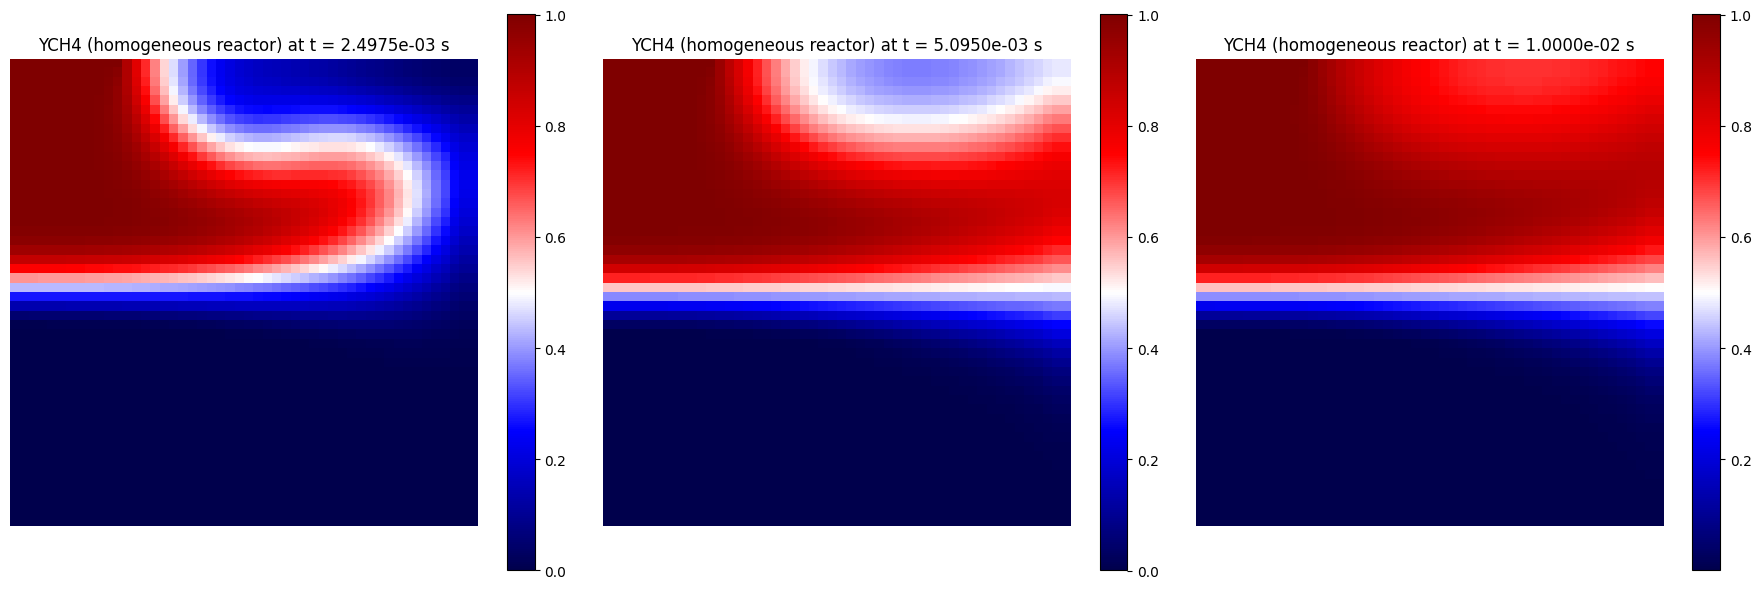

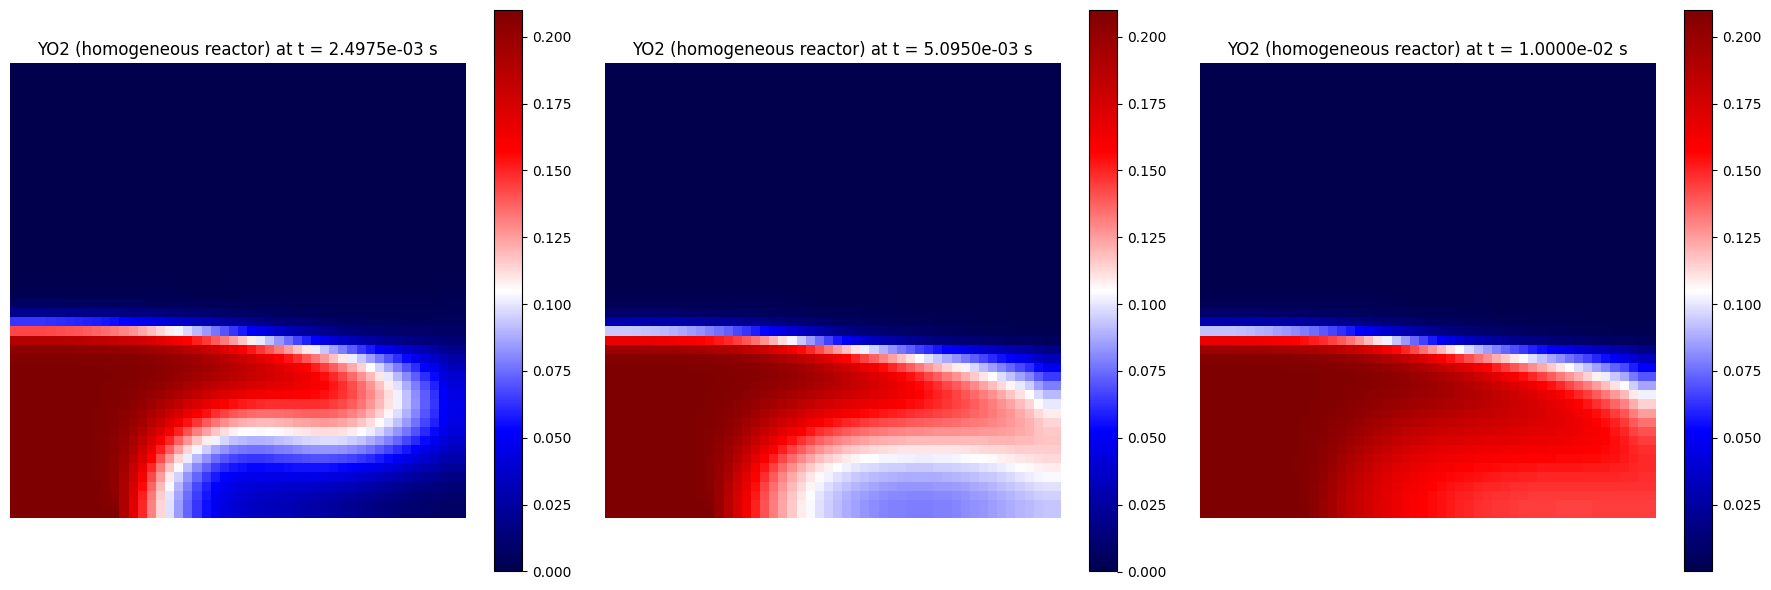

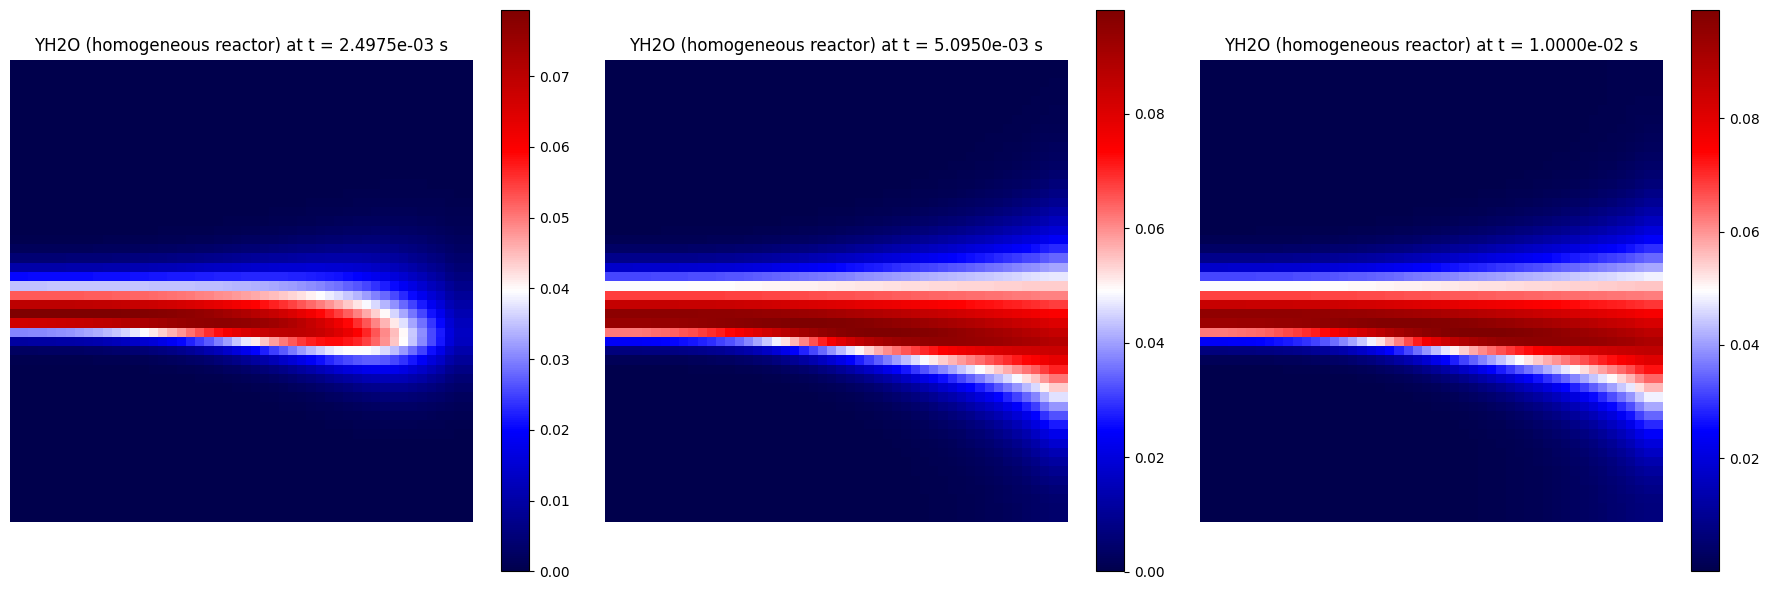

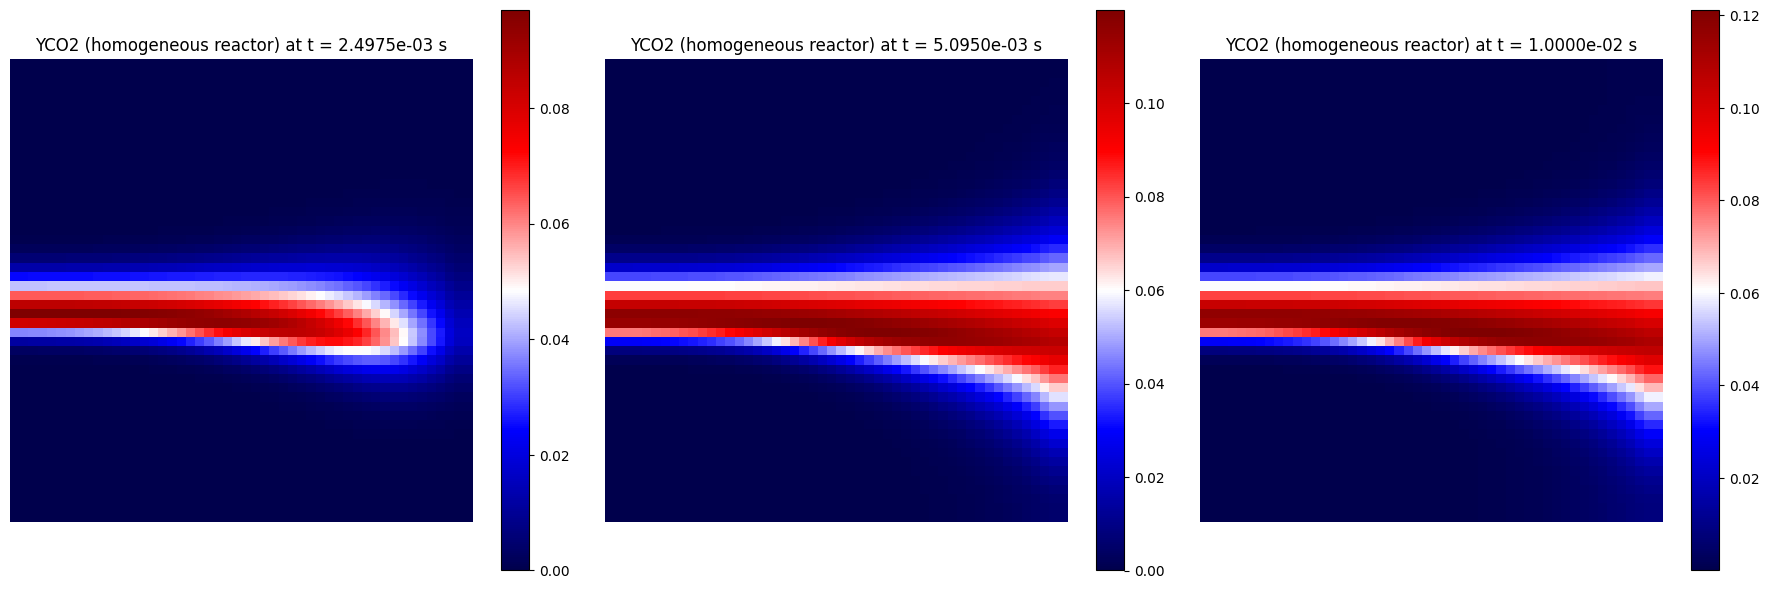

In [9]:
# CH4
plot_species_snapshots(YCH4_h, t_h, Nx,title_prefix="YCH4 (homogeneous reactor)", cmap="seismic")
# O2
plot_species_snapshots(YO2_h, t_h, Nx,title_prefix="YO2 (homogeneous reactor)", cmap="seismic")
# H2O
plot_species_snapshots(YH2O_h, t_h, Nx,title_prefix="YH2O (homogeneous reactor)", cmap="seismic")
# CO2
plot_species_snapshots(YCO2_h, t_h, Nx,title_prefix="YCO2 (homogeneous reactor)", cmap="seismic")

In [12]:
# Full reacting flow with energy equation 

print("Running full reactive flow (reactor)...")

# use max temperature from homogeneous reactor as initial guess
Tmax_reac = 1900
YCH4_r,YO2_r,YH2O_r,YCO2_r,T_r,Ntchem_r,t_r,Temp_max = combustion.reactor(u_flat,v_flat,Nx=Nx,Tf=Tf, Nt=Nt,dt=dt,cp=cp,rho=rho,D=D,a=15e-6,Tmax=Tmax_reac,Nstat=Nstat)
print("Reactive simulation done. Ntchem =", Ntchem_r)


Running full reactive flow (reactor)...
Ntchem = 27183
dthydro =  3.334444814938313e-06
Nthydro= 3000
ratio = 10
dtchem = 3.334444814938313e-07
n= 20
n= 40
n= 60
n= 80
n= 100
n= 120
n= 140
n= 160
n= 180
n= 200
n= 220
n= 240
n= 260
n= 280
n= 300
n= 320
n= 340
n= 360
n= 380
n= 400
n= 420
n= 440
n= 460
n= 480
n= 500
n= 520
n= 540
n= 560
n= 580
n= 600
n= 620
n= 640
n= 660
n= 680
n= 700
n= 720
n= 740
n= 760
n= 780
n= 800
n= 820
n= 840
n= 860
n= 880
n= 900
n= 920
n= 940
n= 960
n= 980
n= 1000
n= 1020
n= 1040
n= 1060
n= 1080
n= 1100
n= 1120
n= 1140
n= 1160
n= 1180
n= 1200
n= 1220
n= 1240
n= 1260
n= 1280
n= 1300
n= 1320
n= 1340
n= 1360
n= 1380
n= 1400
n= 1420
n= 1440
n= 1460
n= 1480
n= 1500
n= 1520
n= 1540
n= 1560
n= 1580
n= 1600
n= 1620
n= 1640
n= 1660
n= 1680
n= 1700
n= 1720
n= 1740
n= 1760
n= 1780
n= 1800
n= 1820
n= 1840
n= 1860
n= 1880
n= 1900
n= 1920
n= 1940
n= 1960
n= 1980
n= 2000
n= 2020
n= 2040
n= 2060
n= 2080
n= 2100
n= 2120
n= 2140
n= 2160
n= 2180
n= 2200
n= 2220
n= 2240
n= 2260
n= 22

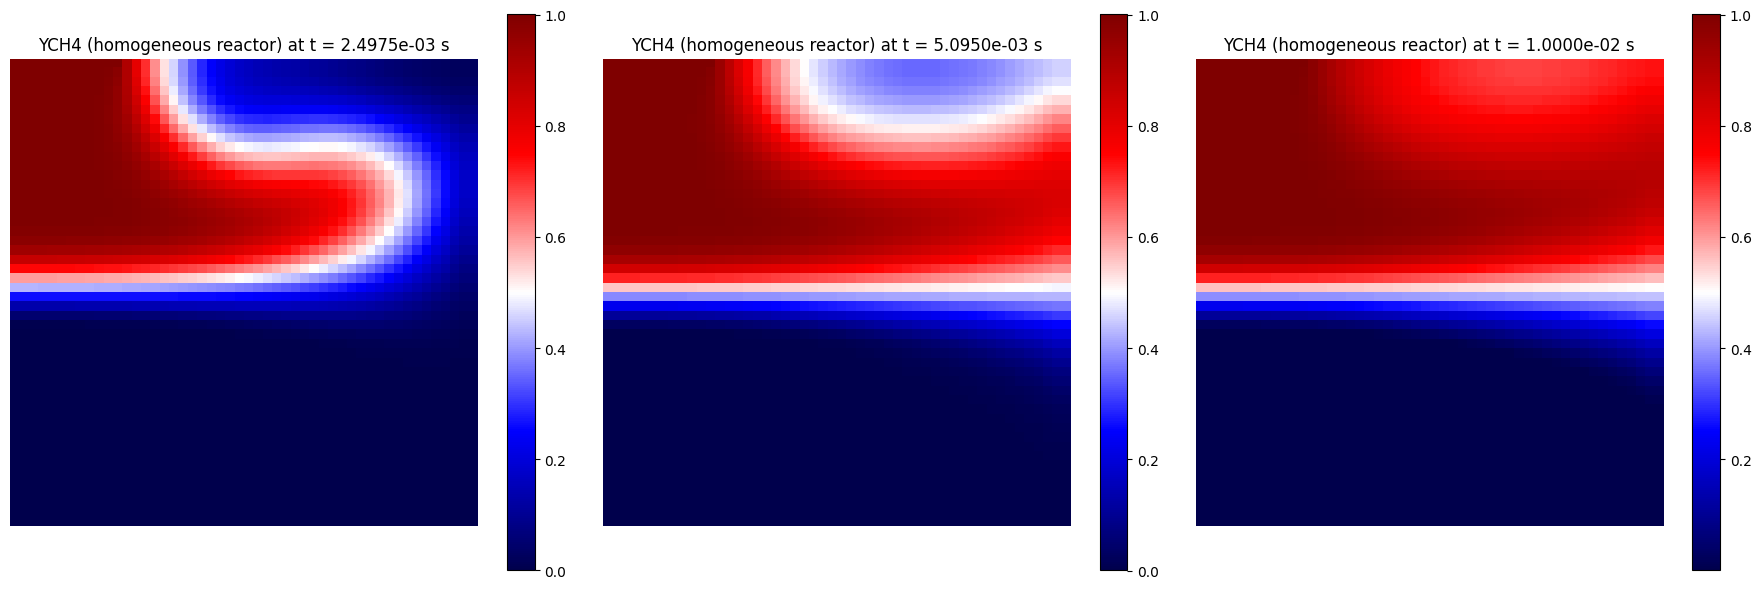

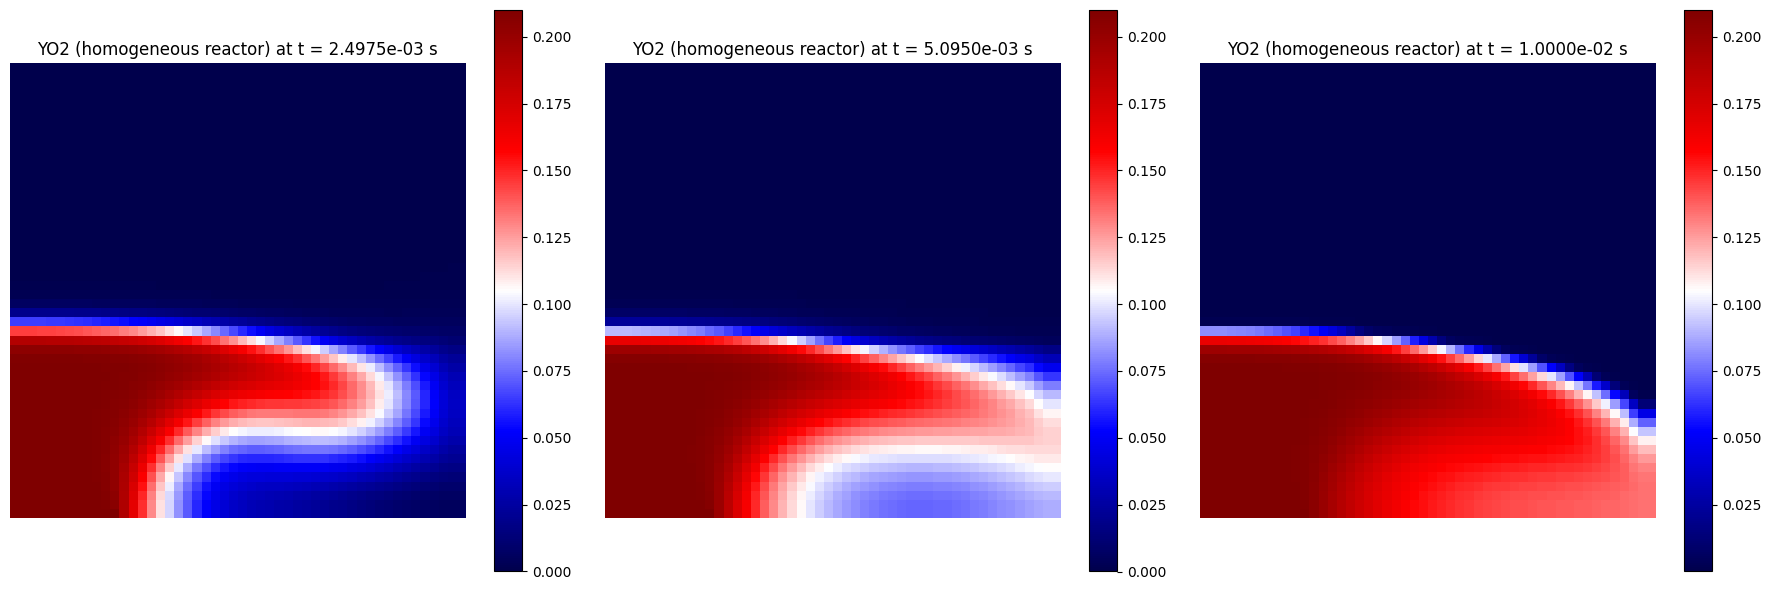

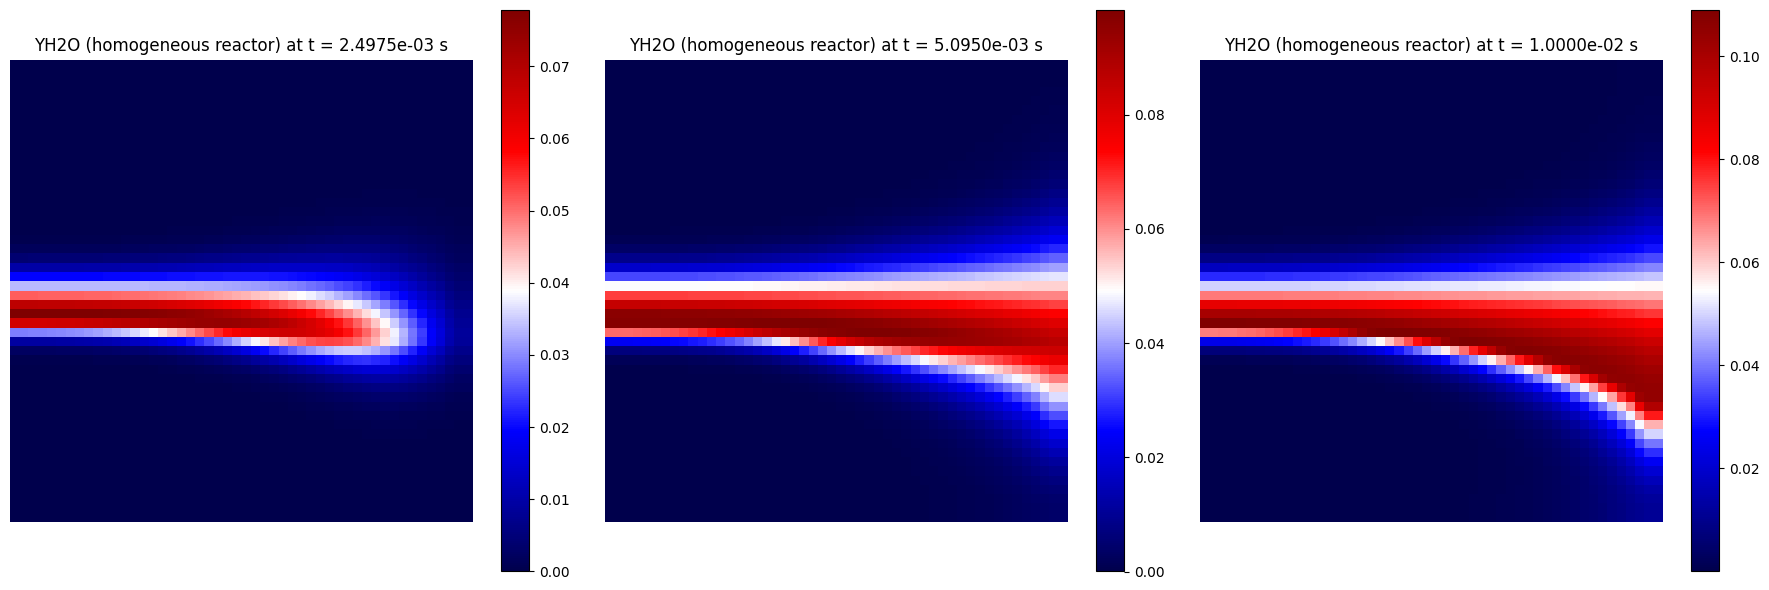

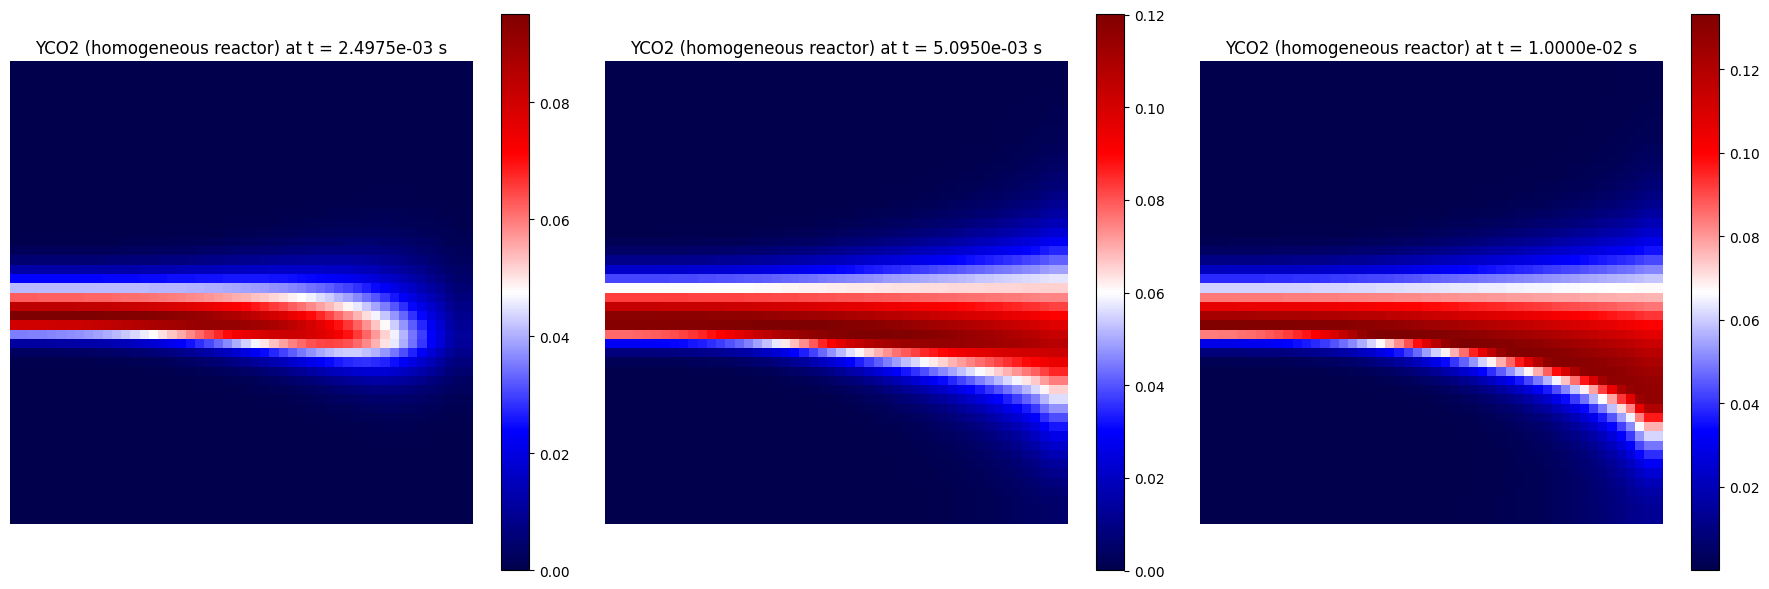

In [14]:
# CH4
plot_species_snapshots(YCH4_r, t_r, Nx,title_prefix="YCH4 (homogeneous reactor)", cmap="seismic")
# O2
plot_species_snapshots(YO2_r, t_r, Nx,title_prefix="YO2 (homogeneous reactor)", cmap="seismic")
# H2O
plot_species_snapshots(YH2O_r, t_r, Nx,title_prefix="YH2O (homogeneous reactor)", cmap="seismic")
# CO2
plot_species_snapshots(YCO2_r, t_r, Nx,title_prefix="YCO2 (homogeneous reactor)", cmap="seismic")

In [15]:
print("Maximum temperature reached:", round(np.max(Temp_max),2), "K")

Maximum temperature reached: 2323.01 K


The temperature reached is indeed between 1700 K and 2500 K as initially predicted. The simulation is therefore conclusive.

In [19]:
#save data
np.save("../data/YCH4.npy", YCH4_r)
np.save("../data/YO2.npy", YO2_r)
np.save("../data/YCO2.npy", YCO2_r)
np.save("../data/YH2O.npy", YH2O_r)
np.save("../data/T.npy", T_r)
np.savetxt("../data/Nstat.txt", [Nstat])